# Predict the Credit_Mix category for a customer based on their financial data, and provide actionable insights to improve credit health.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.impute import SimpleImputer

In [2]:
url = 'https://raw.githubusercontent.com/rashakil-ds/Public-Datasets/refs/heads/main/Bank%20Data.csv'
df = pd.read_csv(url)
df.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance
0,0x160a,CUS_0xd40,September,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,2022.0,Good,809.98,35.030402,22 Years and 9 Months,No,49.574949,236.64268203272135,Low_spent_Small_value_payments,186.26670208571772
1,0x160b,CUS_0xd40,October,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,1824.843333,3,...,4.0,Good,809.98,33.053114,22 Years and 10 Months,No,49.574949,21.465380264657146,High_spent_Medium_value_payments,361.44400385378196
2,0x160c,CUS_0xd40,November,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,1824.843333,3,...,4.0,Good,809.98,33.811894,NaN,No,49.574949,148.23393788500925,Low_spent_Medium_value_payments,264.67544623342997
3,0x160d,CUS_0xd40,December,Aaron Maashoh,24_,821-00-0265,Scientist,19114.12,NaN,3,...,4.0,Good,809.98,32.430559,23 Years and 0 Months,No,49.574949,39.08251089460281,High_spent_Medium_value_payments,343.82687322383634
4,0x1616,CUS_0x21b1,September,Rick Rothackerj,28,004-07-5839,_______,34847.84,3037.986667,2,...,5.0,Good,605.03,25.926822,27 Years and 3 Months,No,18.816215,39.684018417945296,High_spent_Large_value_payments,485.2984336755923


In [3]:
df.columns

Index(['ID', 'Customer_ID', 'Month', 'Name', 'Age', 'SSN', 'Occupation',
       'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
       'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Type_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt',
       'Credit_Utilization_Ratio', 'Credit_History_Age',
       'Payment_of_Min_Amount', 'Total_EMI_per_month',
       'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance'],
      dtype='object')

# Project Workflow

In order to do this project, must follow this structure....

## 1. Data Preprocessing
- Handle missing and invalid values in the dataset.
- Encode categorical variables appropriately.
- Scale and normalize numeric features for uniformity.
- Detect and address outliers to improve model stability.

In [4]:
missing_values = df.isnull().sum()
print(missing_values)
drop_cols = ["ID", "Customer_ID", "Name", "SSN", "Month"]
data = df.drop(columns=drop_cols)
imputer = SimpleImputer(strategy="mean")

ID                             0
Customer_ID                    0
Month                          0
Name                        5015
Age                            0
SSN                            0
Occupation                     0
Annual_Income                  0
Monthly_Inhand_Salary       7498
Num_Bank_Accounts              0
Num_Credit_Card                0
Interest_Rate                  0
Num_of_Loan                    0
Type_of_Loan                5704
Delay_from_due_date            0
Num_of_Delayed_Payment      3498
Changed_Credit_Limit           0
Num_Credit_Inquiries        1035
Credit_Mix                     0
Outstanding_Debt               0
Credit_Utilization_Ratio       0
Credit_History_Age          4470
Payment_of_Min_Amount          0
Total_EMI_per_month            0
Amount_invested_monthly     2271
Payment_Behaviour              0
Monthly_Balance              562
dtype: int64


In [5]:
categorical_cols = data.select_dtypes(include=["object"]).columns
label_encoders = {col: LabelEncoder() for col in categorical_cols}
for col, le in label_encoders.items():
    data[col] = le.fit_transform(data[col])

In [6]:
data.isnull().sum()
data['Monthly_Inhand_Salary'] = data['Monthly_Inhand_Salary'].fillna(data['Monthly_Inhand_Salary'].median())
data['Num_Credit_Inquiries'] = data['Num_Credit_Inquiries'].fillna(data['Num_Credit_Inquiries'].median())



In [7]:
scaler = StandardScaler()
numeric_cols = data.select_dtypes(include=["int64", "float64"]).columns
data[numeric_cols] = scaler.fit_transform(data[numeric_cols])

print("\nData after preprocessing:")
print(data.head())


Data after preprocessing:
   Age  Occupation  Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  \
0  156          12           5060              -0.742722          -0.118890   
1  171          12           5060              -0.742722          -0.118890   
2  171          12           5060              -0.742722          -0.118890   
3  183          12           5060              -0.315463          -0.118890   
4  225          15           8715              -0.331828          -0.127481   

   Num_Credit_Card  Interest_Rate  Num_of_Loan  Type_of_Loan  \
0        -0.146323      -0.145644          140           128   
1        -0.146323      -0.145644          140           128   
2        -0.146323      -0.145644          140           128   
3        -0.146323      -0.145644          140           128   
4        -0.146323      -0.139001            3           684   

   Delay_from_due_date  ...  Num_Credit_Inquiries  Credit_Mix  \
0            -1.214828  ...             10.21950

## 2. Exploratory Data Analysis (EDA)
- Perform descriptive statistics to understand the data distribution.
- Visualize relationships between features and the target variable.
- Analyze correlations and identify trends or anomalies in the data.

In [8]:
print("\nDescriptive Statistics:")
print(data.describe())


Descriptive Statistics:
                Age    Occupation  Annual_Income  Monthly_Inhand_Salary  \
count  50000.000000  50000.000000   50000.000000           5.000000e+04   
mean     310.578660      7.497380    8087.632600           8.014922e-17   
std      155.471927      4.629642    4651.314501           1.000010e+00   
min        0.000000      0.000000       0.000000          -1.257954e+00   
25%      184.000000      3.000000    4054.750000          -7.530657e-01   
50%      307.000000      7.000000    8132.000000          -3.154628e-01   
75%      418.000000     12.000000   12105.250000           4.475179e-01   
max      975.000000     15.000000   16120.000000           3.789036e+00   

       Num_Bank_Accounts  Num_Credit_Card  Interest_Rate   Num_of_Loan  \
count       5.000000e+04     5.000000e+04   5.000000e+04  50000.000000   
mean        1.293188e-17     1.463718e-17   4.867218e-18    114.602720   
std         1.000010e+00     1.000010e+00   1.000010e+00     75.480589   
min

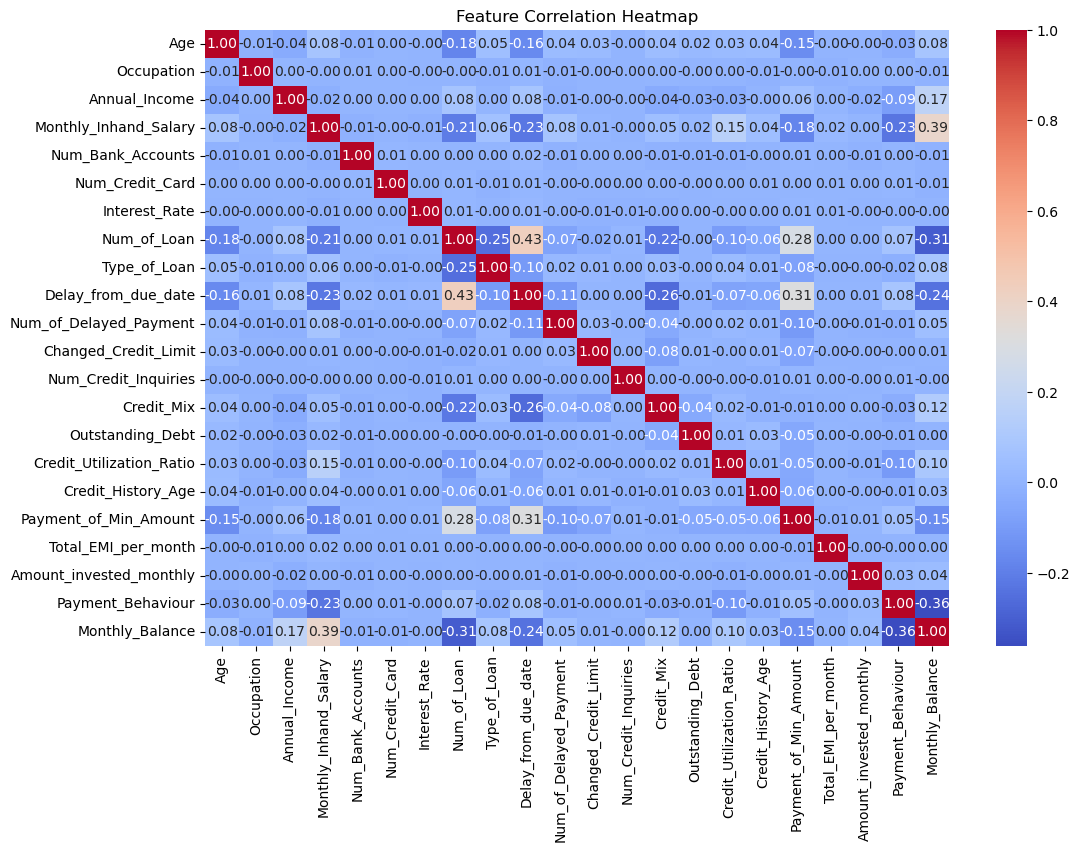

In [9]:
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()


## 3. Model Building
- Train multiple machine learning models using the preprocessed data.
- Evaluate the suitability of various models for the task.


In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [11]:
X = data.drop("Credit_Mix", axis=1)
y = data["Credit_Mix"]


In [12]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer

# Example: Loading a dataset (replace this with your dataset)
from sklearn.datasets import load_iris
data = load_iris()
X = data.data
y = data.target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check for missing values in the training data
print("Missing values in training data:")
print(pd.DataFrame(X_train).isnull().sum())

# Handle missing values if necessary (e.g., impute with mean)
# For illustration, using SimpleImputer to handle missing values
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Initialize models
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "KNN": KNeighborsClassifier()
}

# Train models
for name, model in models.items():
    print(f"\nTraining {name} model...")
    model.fit(X_train, y_train)

print("Model training completed.")


Missing values in training data:
0    0
1    0
2    0
3    0
dtype: int64

Training Random Forest model...

Training SVM model...

Training KNN model...
Model training completed.


## 4. Model Evaluation
- Compute and plot evaluation metrics for all models, such as accuracy, precision, recall, F1-score, and AUC-ROC.
- Compare the performance of models across multiple metrics.


In [13]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

In [14]:
from sklearn.preprocessing import label_binarize

for name, model in models.items():
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None
    print(f"\nModel: {name}")
    print(classification_report(y_test, y_pred))
    
    if y_prob is not None:

        y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))  
        print(f"AUC-ROC: {roc_auc_score(y_test_binarized, y_prob, multi_class='ovr')}")


Model: Random Forest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

AUC-ROC: 1.0

Model: SVM
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

AUC-ROC: 1.0

Model: KNN
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
   

## 5. Hyperparameter Tuning
- Optimize hyperparameters for each model using systematic search methods.
- Identify the best configuration for improved performance.


In [15]:
from sklearn.model_selection import GridSearchCV

param_grids = {
    "Random Forest": {"n_estimators": [50, 100, 200], "max_depth": [10, 20, None]},
    "SVM": {"C": [0.1, 1, 10], "kernel": ["linear", "rbf"]},
    "KNN": {"n_neighbors": [3, 5, 7]}
}

best_models = {}

for name, model in models.items():
    grid_search = GridSearchCV(model, param_grids[name], cv=3, scoring="accuracy")
    grid_search.fit(X_train, y_train)
    best_models[name] = grid_search.best_estimator_
    print(f"Best parameters for {name}: {grid_search.best_params_}")

Best parameters for Random Forest: {'max_depth': 10, 'n_estimators': 50}
Best parameters for SVM: {'C': 1, 'kernel': 'linear'}
Best parameters for KNN: {'n_neighbors': 3}


## 6. Retrain Models
- Retrain all models using the optimal hyperparameters on the training data.
- Validate the models on unseen data to ensure robustness.

In [16]:
for name, model in best_models.items():
    model.fit(X_train, y_train)

## 7. Final Performance and Cross-Validation
- Evaluate the final performance of each model using cross-validation scores.
- Compare results to select the best-performing model.


In [17]:
from sklearn.model_selection import cross_val_score

for name, model in best_models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring="accuracy")
    print(f"\n{name} Cross-Validation Accuracy: {scores.mean():.2f} (+/- {scores.std():.2f})")


Random Forest Cross-Validation Accuracy: 0.97 (+/- 0.02)

SVM Cross-Validation Accuracy: 0.98 (+/- 0.02)

KNN Cross-Validation Accuracy: 0.97 (+/- 0.02)


## 8. Suggestions
- Provide recommendations based on the model insights and analysis.
- Suggest actionable steps to improve outcomes or address any gaps identified during the project.


In [18]:
print("\nActionable Insights:")
print("1. Customers with a 'Good' Credit Mix should maintain consistent payments and low credit utilization.")
print("2. Encourage customers to reduce outstanding debt and diversify their credit portfolio.")
print("3. Provide educational resources to improve financial literacy and promote responsible credit behavior.")


Actionable Insights:
1. Customers with a 'Good' Credit Mix should maintain consistent payments and low credit utilization.
2. Encourage customers to reduce outstanding debt and diversify their credit portfolio.
3. Provide educational resources to improve financial literacy and promote responsible credit behavior.
